## Correct 1D LCT Including Units and Wavelength

In [66]:
import numpy as np
import time as tm
#import math
#import os 
#import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# import scipy.ndimage
# import scipy.ndimage as ip
# from srwlib import *
# from LCTlib import *
import LCTlib as lct

# plt.style.available
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# plt.style.use('Solarize_Light2')
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 15}

***
##### Construct 1D complex Gaussian

In [116]:
phLambda = 0.8e-6               # wavelength [m]; 0.8e-6 m = 800 nm or wavelength of Ti-Sapphire laser
k = 2 * np.pi / phLambda        # wave number
sigmax_gsn_init = 1.3e-3 / 2    # RMS beam size for initial Gsn [m] (w0/2)
print('initial beam size: %g [mm]' %(sigmax_gsn_init*1e3))
sigma_no_gsn_init = 12          # no. of sigmas for initial Gsn range
dist_waist = 0                  # distance from waist [m] (z in the notes)

z_R = 4 * np.pi * sigmax_gsn_init**2 / phLambda    # Rayleigh range 
q_gsn_init = dist_waist + 1j * z_R                 # complex beam parameter for initial Gsn
 
# construct x value array for initial Gsn    
ranx_gsn_init = sigma_no_gsn_init * sigmax_gsn_init   # mesh range for initial Gsn
nx_gsn_init = 1e3                                     # no. of mesh points for initial Gsn
xvals_gsn_init = np.linspace(-ranx_gsn_init, ranx_gsn_init, int(nx_gsn_init))

# construct initial complex Gsn field
E_field_gsn_init = (1 / np.sqrt(np.abs(q_gsn_init))) * np.exp(-1j * k * np.square(xvals_gsn_init) / 2 / q_gsn_init)
int_gsn_init = np.square(np.abs(E_field_gsn_init))

initial beam size: 0.65 [mm]


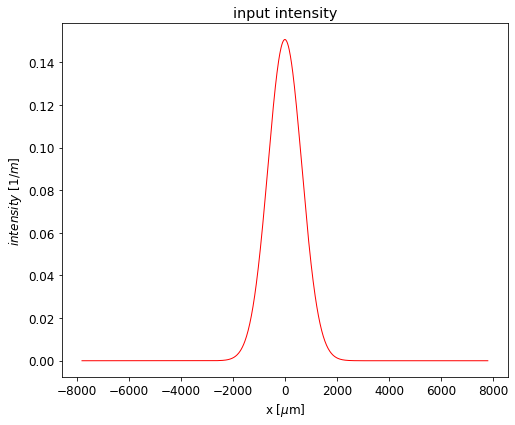

In [103]:
# plot initial intensity
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_gsn_init*1e6, int_gsn_init,'r-', lw = 1)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$intensity$ [$1/m$]')
ax.set_title(r'input intensity')
fig.show()

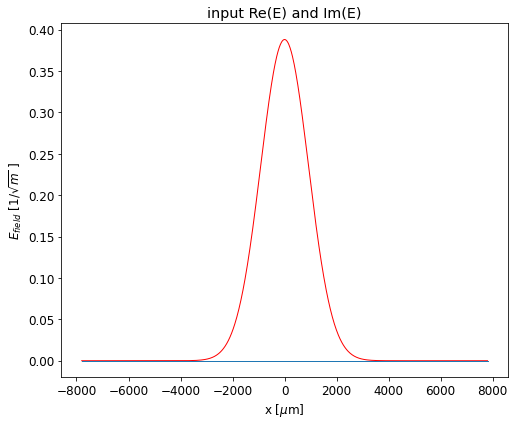

In [104]:
# plot initial Re(E)
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_gsn_init*1e6, np.real(E_field_gsn_init),'r-', lw = 1)
ax.plot(xvals_gsn_init*1e6, np.imag(E_field_gsn_init), lw = 1)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/\sqrt{m}$ ]')
ax.set_title(r'input Re(E) and Im(E)')
fig.show()

***
##### Apply LCT to 1D complex Gaussian

In [209]:
# define matrix for LCT transformation

l_scale = 8e-3                     # scale length in LCT

# lct_mat = lct.rotation_22(360 / 3 * (np.pi / 180.))
L = 20    # drift length [m]
# lct_mat = np.array([[ 1,  L  ],
#                      [ 0, 1 ]])
# lct_mat = np.array([[ 1,  L*phLambda  ],
#                     [ 0, 1 ]])
lct_mat = np.array([[ 1,  L*phLambda/(l_scale**2)  ],
                     [ 0, 1 ]])
print(lct_mat[0,1])

0.25


In [210]:
dx = (xvals_gsn_init[1] - xvals_gsn_init[0])             # horizontal spacing of input signal [m]
# xv = lct_abscissae(nx_init, dX, ishift = False)      # x values array of input signal
du = dx/l_scale
print("dx = %4.3g" % dx)
print("du = %4.3g" % du)

dx = 1.56e-05
du = 0.00195


In [211]:
in_signal = du, E_field_gsn_init     # signal format for input into apply_lct()

In [212]:
t0 = tm.time()
out_signal = lct.apply_lct(lct_mat, in_signal)
t1 = tm.time()
print("LCT runtime: %4.3g seconds" % ((t1 - t0)))  

LCT runtime: 0.00734 seconds


In [213]:
hu_out, sig_arr_out = out_signal   # extract horizontal spacing [m] and E field data respectively from output signal
hx_out = hu_out*l_scale
nx_out = np.size(sig_arr_out)
ranx_out = nx_out * hx_out
# rany_out = ny_out * hy_out
print('prop. hor. range: %g [m]' %(ranx_out)) 

# dX_out = ranx_out / (nx_out - 1)       # horizontal spacing of output signal [m]


xvals_out = lct.lct_abscissae(nx_out, hx_out, ishift = False)

print(hx_out)
print('input mesh: %e points' %(nx_gsn_init))
print('output mesh: %e points' %(nx_out))

prop. hor. range: 0.0312312 [m]
2.4984984984985366e-05
input mesh: 1.000000e+03 points
output mesh: 1.250000e+03 points


In [214]:
np.shape(xvals_out)

(1250,)

In [215]:
# calculate total field magnitude and intensity
E_field_tot_out = np.abs(sig_arr_out)
int_out = np.square(E_field_tot_out)

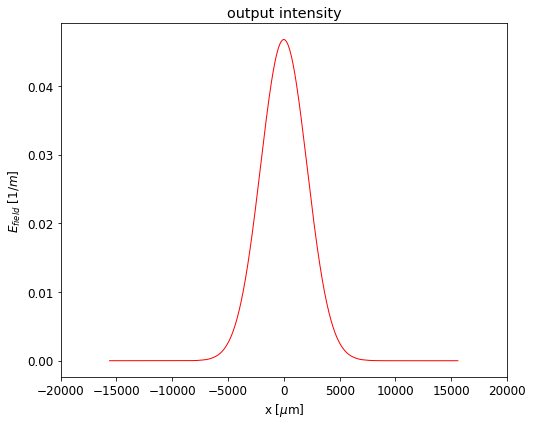

In [216]:
# plot output intensity
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_out*1e6, int_out,'r-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/m$]')
ax.set_title(r'output intensity')
fig.show()

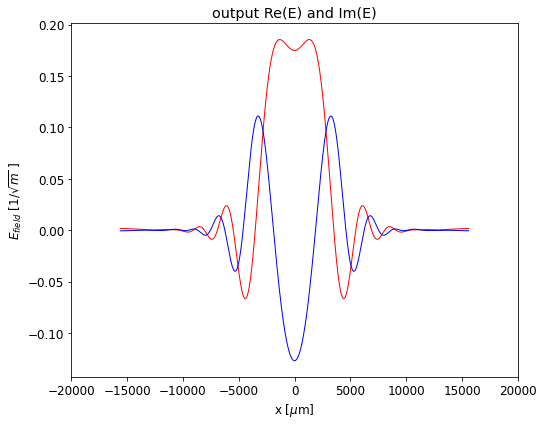

In [217]:
# plot output Re(E)
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_out*1e6, np.real(sig_arr_out),'r-', lw = 1)
ax.plot(xvals_out*1e6, np.imag(sig_arr_out),'b-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/\sqrt{m}$ ]')
ax.set_title(r'output Re(E) and Im(E)')
fig.show()

In [13]:
# lct.resample_signal(4, out_signal, debug = False)